# Introduction
This Jupyter notebook is a companion to a blogpost I wrote for the [Not So Big Data Blog](https://notsobigdatablog.com/2020/04/27/Dua-Lipa-ML-and-colour/), that I co-author. The blog post describes how we can use the K-Means algorithm to extract dominant colours from images, and use it to produce rather spectacular colour timelines for video content.

# Imports

In [24]:
import os
from glob import glob

import numpy as np
import matplotlib
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from PIL import Image
from plotnine import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm

FFMPEG command used to split video into images (video was downloaded using `youtube-dl`):
```
ffmpeg -i dl-bmh.mp4 -crf 0 -vf fps=5  dl-bmh/out_%05d.jpg
```

# Plots that were used to explain how K-Means works

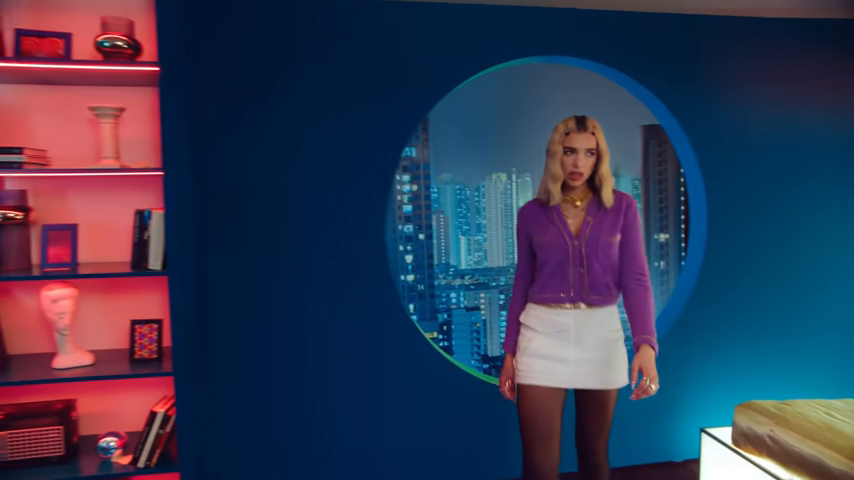

In [2]:
im = Image.open('dua-screencap.png')
im

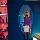

In [3]:
im_smaller = im.resize((40, 40))  # Shrink down the image to speed up K-Means algorithm
im_smaller

In [5]:
arr = np.asarray(im_smaller)
arr.shape

(40, 40, 3)

## Generate hex-color codes for each pixel in the image

In [13]:
arr = arr.reshape(-1, 3)  # Convert into one long array where each element is 3 dimensions (RGB)
arr_scaled = arr / 255  # Scale from 8-bit to between 0-1 to make matplotlib happy

#arr_alpha = [np.concatenate([x, [0.5]]) for x in arr_scaled]
arr_hex = [matplotlib.colors.to_hex(color) for color in arr_scaled]

## Prepare dataframes for 3D plot

In [14]:
# preprocess dataframe
df = pd.DataFrame({
    'r': arr[:, 0],
    'g': arr[:, 1],
    'b': arr[:, 2],
    'color_hex': arr_hex
})

df = df.reset_index()
df.head()

color_hex = df['color_hex'].values

## Create 3D plot
(Plotly unfortunately forces you to write a little bit of ugly code in order to get this to work)

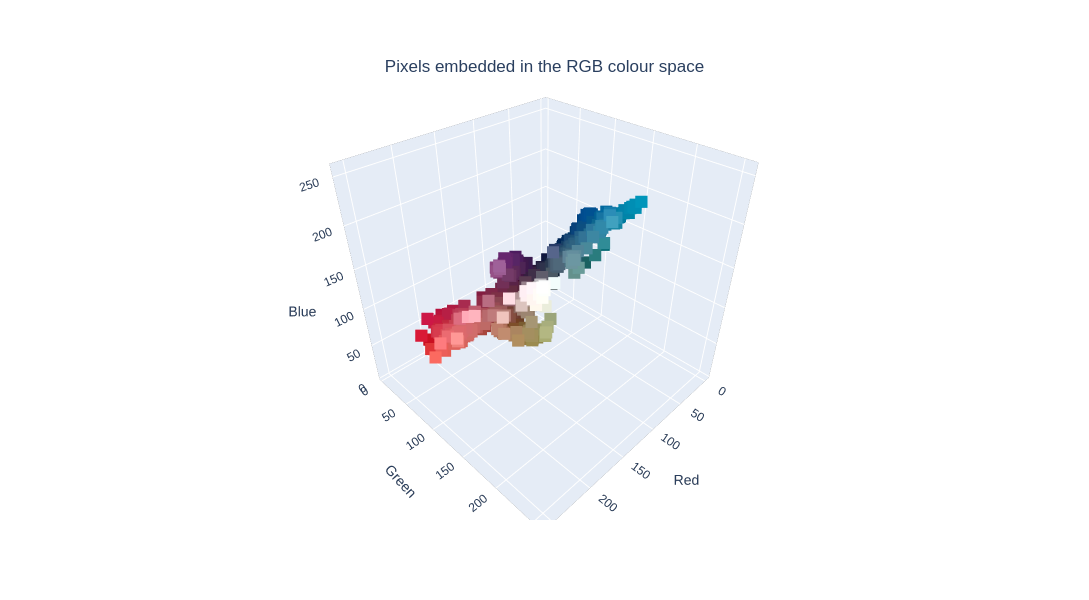

In [15]:

my_data = [go.Scatter3d(x=df.r,
                        y=df.g,
                        z=df.b,
                        mode='markers',
                       marker={'size': 4, 'symbol': 'square', 'color': df['color_hex'], 'opacity': 1})]
# Critical to set `showlegend` to False! Otherwise we get a separate entity in the legend for *each* colour!
# (this will break your browser)
my_layout = go.Layout(showlegend= False, scene=go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='Red'),
        yaxis=go.layout.scene.YAxis(title='Green'),
        zaxis=go.layout.scene.ZAxis(title='Blue'),
    ),
                      height=600,
                      width=800,
                      margin={'t': 50},
                      title={'text': 'Pixels embedded in the RGB colour space',
                             'x': 0.5,
                             'y': 0.9,
                             'xanchor': 'center'}
)
fig = go.Figure(data=my_data, layout=my_layout)
config = dict({'scrollZoom': True})
fig.show(config=config)
fig.write_html('/home/michael/Code/notsobigdatablog/_posts/dua-lipa-ml-plotly/3d_pixel_plotly.html', include_plotlyjs='cdn', full_html=False, config=config)

## Projecting down to 2D in order to make telling the story easier

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: /home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_plain.png



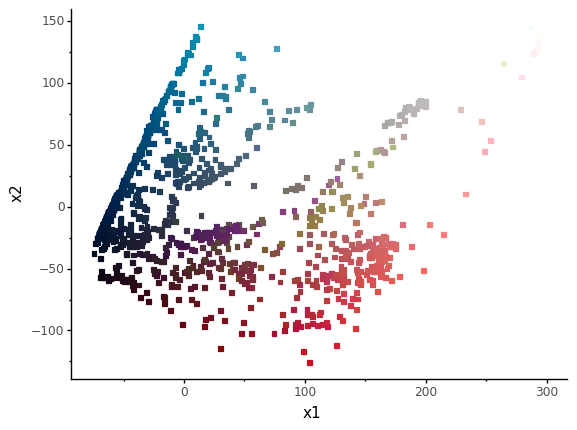

<ggplot: (8789478941416)>

In [16]:
# Project to 2D using PCA
pca = PCA(n_components=2)
arr_2d = pca.fit_transform(arr)

df = pd.DataFrame({
    'x1': arr_2d[:, 0],
    'x2': arr_2d[:, 1],
    'color': range(len(arr_2d))
})

# Plot using plotnine
p = ggplot(aes(x='x1', y='x2', color='factor(color)'), df)
p = p + geom_point(shape='s') + scale_color_manual(color_hex, guide=False) + theme_classic() + theme(plot_background=element_rect(fill='white', color='white'))
p.save('/home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_plain.png', dpi=200)
p

## Let's do the actual clustering

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: /home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_clusters.png



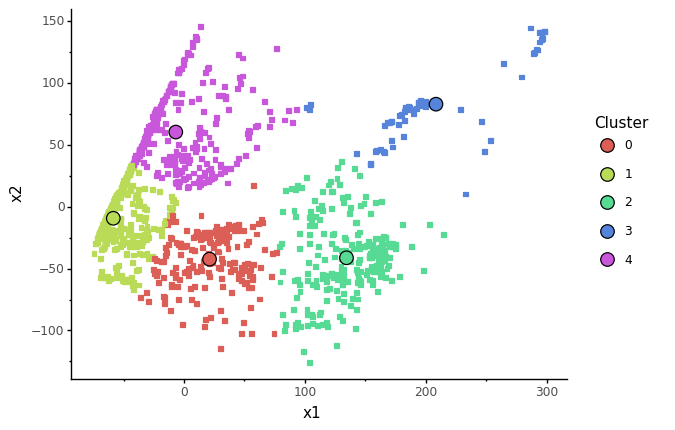

<ggplot: (8789469911465)>

In [17]:
km = KMeans(n_clusters=5)
km.fit(arr_2d)
dist_to_centroids = km.transform(arr_2d)
closest_centroid = km.predict(arr_2d)
cluster_centers = km.cluster_centers_

# Let's plot previous data points again *and* centroids
df = pd.DataFrame({
    'x1': arr_2d[:, 0],
    'x2': arr_2d[:, 1],
    'type': 'datapoint',
    'label': closest_centroid
})

df = df.reset_index()

df2 = pd.DataFrame({
    'x1': cluster_centers[:, 0],
    'x2': cluster_centers[:, 1],
    'type': 'centroid',
    'label': range(len(cluster_centers))
})

df2 = df2.reset_index()

p = ggplot(aes(x='x1', y='x2'), df)
p = (
    p
    + geom_point(aes(color='factor(label)'), shape='s') # + scale_color_manual(color_hex, guide=False)
    + geom_point(aes(fill='factor(label)'), data=df2, size=5, stroke=0.5)
    + theme_classic() + theme(plot_background=element_rect(fill='white', color='white'))
    + labs(fill='Cluster', color='Cluster')
)

p.save('/home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_clusters.png', dpi=200)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: /home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_clusters_color.png



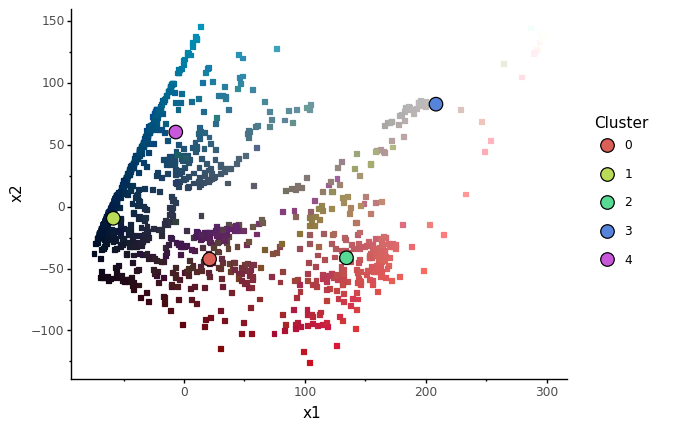

<ggplot: (-9223363247375963441)>

In [18]:
# Let's plot previous plot bit add the pixel color back in
df = pd.DataFrame({
    'x1': arr_2d[:, 0],
    'x2': arr_2d[:, 1],
    'type': 'datapoint',
    'color': range(len(arr_2d))  # <-- make each color the pixel color again
})

df = df.reset_index()

df2 = pd.DataFrame({
    'x1': cluster_centers[:, 0],
    'x2': cluster_centers[:, 1],
    'type': 'centroid',
    'label': range(len(cluster_centers))
})

df2 = df2.reset_index()

p = ggplot(aes(x='x1', y='x2'), df)
p = (
    p
    + geom_point(aes(color='factor(color)'), shape='s') + scale_color_manual(color_hex, guide=False)
    + geom_point(aes(fill='factor(label)'), data=df2, size=5, stroke=0.5)
    + theme_classic() + theme(plot_background=element_rect(fill='white', color='white'))
    + labs(fill='Cluster', color='Cluster')
)

p.save('/home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/2d_pixels_clusters_color.png', dpi=200)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: /home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/cluster_size.png



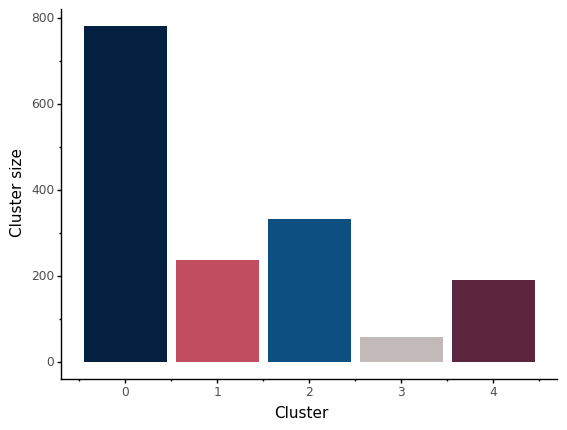

<ggplot: (-9223363290290317038)>

In [45]:
# Look at the size of each of these clusters
clusters, counts = np.unique(closest_centroid, return_counts=True)

# Get the color closest to each centroid (for the bar plot)
centroid_color = []
for centroid_number in range(len(clusters)):
    closest = np.argmin(dist_to_centroids[:, centroid_number])
    centroid_color.append(color_hex[closest])

# Make the plot
df = pd.DataFrame({
    'Cluster': range(len(clusters)),
    'Cluster size': counts
})

p = ggplot(aes(x='Cluster', y='Cluster size', fill='factor(Cluster)'), df)
p = p + geom_bar(stat='identity') \
  + scale_fill_manual(centroid_color, guide=False) \
  + theme_classic() \
  + theme(plot_background=element_rect(fill='white', color='white'))

p.save('/home/michael/Code/notsobigdatablog/assets/dua-lipa-ml/cluster_size.png', dpi=200)
p

# Creating the colour timelines

In [25]:
def get_dominant_colors(im, resize=(20, 20), n_clusters=5):
    """Extract the dominant colours from a PIL image."""
    im = im.resize(resize)
    arr = np.asarray(im)
    shape = arr.shape
    arr = arr.reshape(shape[0]*shape[1], shape[2])  # Turn into 2D array (n, 3)

    km = KMeans(n_clusters=n_clusters, n_init=3)
    km.fit(arr)
    arr_transform = km.transform(arr)
    labels = km.predict(arr)
    
    # Count the size of each cluster
    clusters, counts = np.unique(labels, return_counts=True)
    sorted_clusters_counts_desc = sorted(zip(clusters, counts), key=lambda x: x[1])[::-1]
    # Sort the clusters by number of pixels belonging to them
    sorted_clusters_desc = [cluster for cluster, _ in sorted_clusters_counts_desc]
    # Extract the closest pixel to each cluster
    closest_to_clusters = []
    for c in sorted_clusters_desc:
        closest_to_clusters.append(np.argmin(arr_transform[:, c]))
    # Get the colour of each pixel
    dominant_colors = [arr[pixel] for pixel in closest_to_clusters]
    return dominant_colors
    

In [26]:
def make_preview(pixel_value, size=(150, 150)):
    arr = np.full(size, pixel_value, dtype=(int, 3))
    return Image.fromarray(np.uint8(arr))

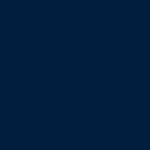

In [27]:
# Test run
dc = get_dominant_colors(im)
make_preview(dc[0])

In [75]:
# Ok, let's do this for all of the images in a folder + stitch them together

image_width_px = 600
root_path = 'g-ffyl/'
images = glob(os.path.join(root_path, '*.jpg'))
images = sorted(images)
step_size = int(len(images)/ image_width_px)
images = images[::step_size]
images = images[:image_width_px]

im_list = []
colors = []
for im_path in tqdm(images):
    im = Image.open(im_path)  # <-- this is a really expensive operation
    dominant_colors = get_dominant_colors(im, resize=(30, 30), n_clusters=5)
    colors.append(dominant_colors[0])
    im.close()

100%|██████████| 600/600 [00:12<00:00, 48.09it/s]


In [71]:
def build_output_image(colors, height):
    """Build a colour timeline image"""
    # Speccing dtype with dimension 3 is important here!
    output = np.empty((height, len(colors)), dtype=(int, 3)) 
    for i, c in enumerate(colors):
        output[:, i] = c
    return Image.fromarray(np.uint8(output))

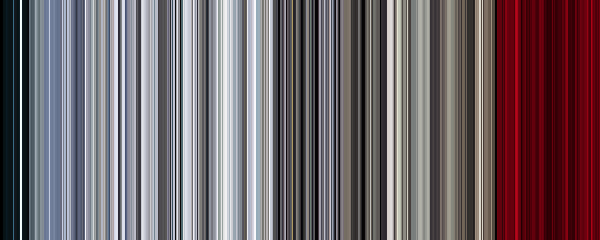

In [76]:
output_im = build_output_image(colors, height=int(len(colors)/2.5))
output_im